In [1]:
# RYAN SLATTERY
# CS584 - NATURAL LANGUAGE PROCESSING
# START DATE: MARCH 21, 2022
# LAST MODIFIED: MAY 06, 2022

In [2]:
# IMPORTING LIBRARIES

import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
import spacy
import re
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# GENERATING AND SHUFFLING OUR DATA:
# Since the Kaggle Dataset is organized by class (the first half of the dataset is all class 1, and the second half is
# all class 0), I decided to shuffle the data.
data = pd.read_csv("https://raw.githubusercontent.com/rtslattery13/ClickbaitCNN/main/clickbait_data.csv")
data = data.sample(frac = 1)

headlines = data['headline'].values.tolist()
labels = data['clickbait'].values.tolist()

# SEPARATING OUR TESTING/TRAINING DATA:
train_texts, valid_texts, train_labels, valid_labels = train_test_split(headlines, labels, test_size = 0.1)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.1)

print("THE SIZE OF THE TRAINING SET IS:", len(train_texts))
print("THE SIZE OF THE VALIDATION SET IS:", len(valid_texts))
print("THE SIZE OF THE TESTING SET IS:", len(test_texts))

THE SIZE OF THE TRAINING SET IS: 25952
THE SIZE OF THE VALIDATION SET IS: 3204
THE SIZE OF THE TESTING SET IS: 2884


In [4]:
nlp = spacy.load('en_core_web_sm')

# FEATURE EXTRACTION:
class TF_IDF(object):
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.tf = defaultdict(lambda: 0)
        self.df = defaultdict(lambda: 0)
        self.word2idx = {}
        
    # PREPROCESSING METHOD:
    # INPUT: text (a string of text)
    # OUTPUT: text (a cleaned version of the input text)
    # A simple preprocessor function that replaces uppercase letters with lowercase ones, and removes punctuation, 
    # numbers, and urls (if there are any... it is unlikely since the text only consists of headlines).
    def Preprocessor(self, text):
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[0-9]+', '', text)
        text = text.lower()

        return text
    
    # TOKENIZER METHOD:
    # INPUT: text (a string of text)
    # OUTPUT: tokens (a list of tokens)
    def Tokenizer(self, text):
        docs = nlp.tokenizer.pipe(text, batch_size = 1000)
        tokens = []

        for doc in docs:
            for token in doc:
                if token.is_stop == False:
                    tokens.append(token)

        return tokens
    
    # COUNT STOP WORDS METHOD:
    # INPUT: text (a string of text)
    # OUTPUT: len(stops) (number of stopwords within the input text)
    def CountStopWords(self, text):
        docs = nlp.tokenizer.pipe(text, batch_size = 1000)
        stops = 0
        length = 0
        
        for doc in docs:
            stops = [token for token in doc if token.is_stop == True]
            length = [token for token in doc]

        return len(stops), len(stops)/len(length)
    
    # PRONOUN SCORE METHOD:
    # INPUT: text (a string of text)
    # OUTPUT: score (number of pronouns over length of text)
    def PronounScore(self, text):
        pronouns = ["i", "you", "we'll", "he", "she", "him", "her", "you'll", "your", "his", "hers", "they", "them", "theirs", "me", "mine", "it", "yours", "we", "their", "my"]
        text = text.lower()
        text = text.split()
        
        pros = [word for word in text if word in pronouns]
        score = len(pros)/len(text)
        
        return len(pros), score
        
 
    # FIT METHOD:
    # INPUT: texts (a list of texts)
    # Calls on the Preprocessor and Tokenizer to clean and tokenize the text. Takes the resulting tokens and 
    # stores them within the tf and df dictionaries initialized in the constructor.
    def Fit(self, texts):
        num_text = 0
        self.tf['<PAD>'] = 0
        self.df['<PAD>'] = 0
        
        for text in tqdm(texts, desc = 'FITTING TEXTS'):
            clean_text = self.Preprocessor(text)
            tokens = self.Tokenizer([clean_text])
            
            for token in tokens:
                self.df[token.text_with_ws] += 1
                
                if (token.text_with_ws not in self.tf):
                    self.tf[token.text_with_ws] = [num_text]
                else:
                    self.tf[token.text_with_ws].append(num_text)
            
            num_text += 1
        
        
        if self.tf is not None:
            self.tf = {key: self.tf[key] for key in list(self.tf.keys())[:self.vocab_size]}
        
        self.word2idx = {key: idx for idx, key in enumerate(self.tf.keys())}

    
    # TRANSFORM METHOD:
    # INPUT: texts (list of texts), sequence_length (defined length of sequences)
    # OUTPUT: tf_idf (feature vectors), text_index_list (indices for each word in the vocabulary, for each doc), 
    # num_stop_words (number of stop words for each document)
    def Transform(self, texts, sequence_length):
        tf_idf = np.zeros((len(texts), self.vocab_size))
        num_stop_words = np.zeros((len(texts), 1))
        num_pronouns = np.zeros((len(texts), 1))
        stop_words_ratio = np.zeros((len(texts), 1))
        pronoun_score = np.zeros((len(texts), 1))
        text_index_list = np.zeros((len(texts), sequence_length))
        
        for i, text in tqdm(enumerate(texts), desc = 'TRANSFORMING', total = len(texts)):
            clean_text = self.Preprocessor(text)
            tokens = self.Tokenizer([clean_text])
            num_stops, stop_ratio = self.CountStopWords([clean_text])
            num_stop_words[i] = num_stops
            stop_words_ratio[i] = stop_ratio
            num_pros, pronoun_score[i] = self.PronounScore(text)
            num_pronouns[i] = num_pros
        
            doc_words = len(tokens)

            tf = 0
            idf = 0
            count = 0
            for item in tokens:
                if self.tf.get(item.text_with_ws) is not None:
                    if (count < sequence_length):
                        text_index_list[i][count] = self.word2idx[item.text_with_ws]
                        count += 1
                    tf_idf[i][self.word2idx[item.text_with_ws]] += (1/doc_words) * np.log((len(texts)/self.df[item.text_with_ws]))
        
        tf_idf = np.append(tf_idf, stop_words_ratio, axis = 1)
        tf_idf = np.append(tf_idf, pronoun_score, axis = 1)
        return tf_idf, text_index_list, num_stop_words, num_pronouns
        

In [5]:
vocab_size = 10000
sequence_length = 10

tfidf_extractor = TF_IDF(vocab_size)
tfidf_extractor.Fit(train_texts)

train_set, train_indices, train_stops, train_pronouns = tfidf_extractor.Transform(train_texts, sequence_length)
valid_set, valid_indices, valid_stops, valid_pronouns = tfidf_extractor.Transform(valid_texts, sequence_length)
test_set, test_indices, test_stops, test_pronouns = tfidf_extractor.Transform(test_texts, sequence_length)

FITTING TEXTS:   0%|          | 0/25952 [00:00<?, ?it/s]

TRANSFORMING:   0%|          | 0/25952 [00:00<?, ?it/s]

TRANSFORMING:   0%|          | 0/3204 [00:00<?, ?it/s]

TRANSFORMING:   0%|          | 0/2884 [00:00<?, ?it/s]

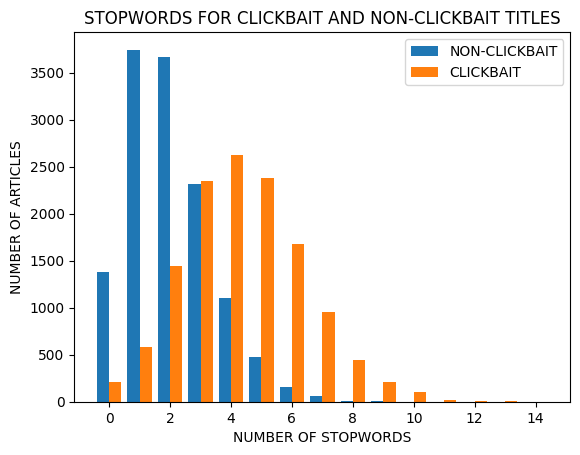

In [6]:
# VISUALIZATION OF STOPWORDS BETWEEN CLICKBAIT AND NON-CLICKBAIT TEXTS
stops_0 = np.zeros((15, 1))
stops_1 = np.zeros((15, 1))

for i in range(len(train_stops)):
    if (train_labels[i] == 1):
        stops_1[int(train_stops[i])] += 1
    else:
        stops_0[int(train_stops[i])] += 1

x = np.arange(15)
plt.bar(x-0.2, stops_0.flatten(), 0.4)
plt.bar(x+0.2, stops_1.flatten(), 0.4)
plt.title('STOPWORDS FOR CLICKBAIT AND NON-CLICKBAIT TITLES')
plt.ylabel('NUMBER OF ARTICLES')
plt.xlabel('NUMBER OF STOPWORDS')
plt.legend(['NON-CLICKBAIT', 'CLICKBAIT'])

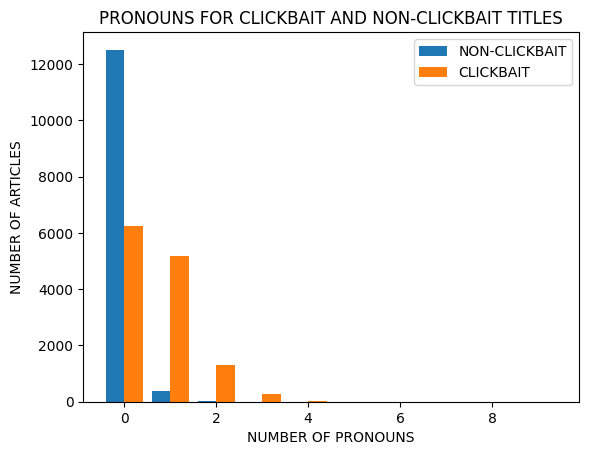

In [7]:
# VISUALIZATION OF PRONOUNS BETWEEN CLICKBAIT AND NON-CLICKBAIT TEXTS
pros_0 = np.zeros((10, 1))
pros_1 = np.zeros((10, 1))

for i in range(len(train_pronouns)):
    if(train_labels[i] == 1):
        pros_1[int(train_pronouns[i])] += 1
    else:
        pros_0[int(train_pronouns[i])] += 1
    
x = np.arange(10)
plt.bar(x-0.2, pros_0.flatten(), 0.4)
plt.bar(x+0.2, pros_1.flatten(), 0.4)
plt.title('PRONOUNS FOR CLICKBAIT AND NON-CLICKBAIT TITLES')
plt.ylabel('NUMBER OF ARTICLES')
plt.xlabel('NUMBER OF PRONOUNS')
plt.legend(['NON-CLICKBAIT', 'CLICKBAIT'])

In [8]:
# HYPERPARAMETERS:
embedding_size = 300
hidden_size = 300

# HYPERPARAMETERS FOR LOGISTIC REGRESSION:
num_epochs_logreg = 25
learning_rate_logreg = 0.005

# HYPERPARAMETERS FOR CNN:
num_epochs_cnn = 10
learning_rate_cnn = 0.001
num_kernels_cnn = 20

# HYPERPARAMETERS FOR CNN W/ EMBEDDINGS:
num_epochs_cnn_e = 20
learning_rate_cnn_e = 0.025
num_kernels_cnn_e = 20

In [9]:
from pickle import TRUE
# BASIC LOGISTIC REGRESSION MODEL:
# Contains one output layer, with the result transformed by the sigmoid activation function.
class LogisticRegression(nn.Module):
    
    # CLASS CONSTRUCTOR:
    # INPUT: vocab_size (size of vocabulary)
    # NOTE: vocab_size + 2 for input layer due to 2 extra features that were added.
    def __init__(self, vocab_size):
        super(LogisticRegression, self).__init__()
        
        self.output_layer = nn.Linear(vocab_size + 2, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.3)
    
    # FORWARD PROPOGATION METHOD:
    # INPUT: x (input data)
    # OUTPUT: y_hat (predicted values between 0 and 1)
    # Each batch of inputs get transformed by the linear output layer and the sigmoid activation.
    def forward(self, x):
        output = self.dropout(self.output_layer(x))
        y_hat = torch.squeeze(self.sigmoid(output))
        
        return y_hat

# CONVOLUTIONAL NEURAL NETWORK MODEL:
# Contains a hidden layer, convolution layer, and output layer from a fully-connected feedforward network.
class ClickbaitCNN(nn.Module):
    
    # CLASS CONSTRUCTOR:
    # INPUT: vocab_size (size of vocabulary), hidden_size (size of the hidden layer), num_kernels (number of kernels)
    def __init__(self, vocab_size, hidden_size, num_kernels):
        super(ClickbaitCNN, self).__init__()
        
        self.hidden_layer = nn.Linear(vocab_size + 2, hidden_size)
        self.CNN = nn.Conv1d(hidden_size, num_kernels, kernel_size = 1)
        self.pooling = nn.MaxPool1d(num_kernels)
        self.output_layer = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.2)
        
    # FORWARD PROPOGATION METHOD:
    # INPUT: x (input data)
    # OUTPUT: y_hat (predicted values between 0 and 1)
    # Each batch of data is transformed by the linear hidden layer, 1D convolution layer, and max-pooled. The processed
    # input then gets transformed by another linear output layer and the sigmoid function.
    # Slight dropout was included to prevent overfitting.
    def forward(self, x):
        x = self.dropout(torch.unsqueeze(self.hidden_layer(x), 2))
        conv = torch.squeeze(self.CNN(x), 2)
        conv = self.pooling(conv)
        output = self.output_layer(conv)
        y_hat = torch.squeeze(self.sigmoid(output), 1)
        
        return y_hat
    
# TRAINED WORD EMBEDDING CONVOLUTIONAL NEURAL NETWORK MODEL:
# Contains an embedding layer, convolution layer, and output layer from a fully-connected feedforward network.
# The convolution was done with unigrams, as larger order n-grams had issues due to short sequences.
class ClickbaitCNN_E(nn.Module):
    
    # CLASS CONSTRUCTOR:
    # INPUT: vocab_size (size of vocabulary), embedding_size (size of the embedding layer), num_kernels (number of kernels)
    def __init__(self, vocab_size, embedding_size, num_kernels, sequence_length):
        super(ClickbaitCNN_E, self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.CNN = nn.Conv1d(embedding_size, 1, kernel_size = 1)
        self.pooling = nn.MaxPool1d(sequence_length)
        self.output_layer = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.1)
    
    # FORWARD PROPOGATION METHOD:
    # INPUT: x (input data)
    # OUTPUT: y_hat (predicted values between 0 and 1)
    # Each batch of indices is connected with the embedding layer, 1D convolution layer, and max-pooled. The processed
    # input then gets transformed by another linear output layer and the sigmoid function.
    # Slight dropout was included to prevent overfitting.
    def forward(self, x):
        e = self.dropout(torch.transpose(self.embedding_layer(x), 1, 2))
        conv = self.CNN(e)
        conv = self.pooling(conv)
        output = self.output_layer(conv)
        y_hat = torch.squeeze(torch.squeeze(self.sigmoid(output), 2), 1)
        
        return y_hat
        

In [10]:
LogReg = LogisticRegression(vocab_size)
print(LogReg)

CNN = ClickbaitCNN(vocab_size, hidden_size, num_kernels_cnn)
print(CNN)

CNN_E = ClickbaitCNN_E(vocab_size, embedding_size, num_kernels_cnn_e, sequence_length)
print(CNN_E)

LogisticRegression(
  (output_layer): Linear(in_features=10002, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)
ClickbaitCNN(
  (hidden_layer): Linear(in_features=10002, out_features=300, bias=True)
  (CNN): Conv1d(300, 20, kernel_size=(1,), stride=(1,))
  (pooling): MaxPool1d(kernel_size=20, stride=20, padding=0, dilation=1, ceil_mode=False)
  (output_layer): Linear(in_features=1, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)
ClickbaitCNN_E(
  (embedding_layer): Embedding(10000, 300)
  (CNN): Conv1d(300, 1, kernel_size=(1,), stride=(1,))
  (pooling): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (output_layer): Linear(in_features=1, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [11]:
# STOCHASTIC GRADIENT DESCENT TRAINING METHOD:
# INPUT: model (model type), training_data (features or embeddings), training_labels (0 and 1), validation_data,
# validation_labels, num_epochs (number of epochs **HYPERPARAMETER**), learning_rate (learning rate **HYPERPARAMETER**)
# embed (boolean value that converts embedding indices into proper type)
# For each epoch, SGD randomly selects instances from the entire training set, feeds them into the model, and calculates
# the loss from the output. Binary Cross Entropy Loss is used in this case.
# Validation data and labels are passed in as a full batch and are evaluated at the end of each epoch.
def SGD(model, training_data, training_labels, validation_data, validation_labels, num_epochs, learning_rate, embed = False):
    train_losses = []
    valid_losses = []
    
    model_optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    criterion = nn.BCELoss()
    
    for i in tqdm(range(num_epochs), desc = "TRAINING MODEL"):
        total_train_loss = 0
        for j in range(len(training_data)):
            rand = np.random.randint(0, len(training_data))
            
            x = torch.unsqueeze(torch.tensor(training_data[rand], dtype = torch.float), 0)
            if (embed == True):
                x = torch.unsqueeze(torch.tensor(training_data[rand], dtype = torch.long), 0)
                
            y = torch.tensor(training_labels[rand], dtype = torch.float)
            
            y_hat = model(x)
            train_loss = criterion(torch.squeeze(y_hat), y)
            total_train_loss += train_loss
            
            train_loss.backward()
            model_optimizer.step()
            model_optimizer.zero_grad()
            
        
        print("TRAINING LOSS AT EPOCH", i + 1, "IS:", float(total_train_loss / len(training_data)))
        train_losses.append(float(total_train_loss / len(training_data)))
        
        valid_loss = 0
        valid_x = torch.tensor(validation_data, dtype = torch.float)
        if (embed == True):
            valid_x = torch.tensor(validation_data, dtype = torch.long)
        valid_y = torch.tensor(valid_labels, dtype = torch.float)
        valid_y_hat = model(valid_x)
        valid_loss = criterion(valid_y_hat, valid_y)
        
        print("VALIDATION LOSS AT EPOCH", i + 1, "IS:", float(valid_loss), '\n')
        valid_losses.append(float(valid_loss))
        
    
    return train_losses, valid_losses
            
            

In [12]:
# TRAINING THE LOGISTIC REGRESSION MODEL:
logreg_train_losses, logreg_valid_losses = SGD(LogReg, train_set, train_labels, valid_set, valid_labels, num_epochs_logreg, learning_rate_logreg, False)

TRAINING MODEL:   0%|          | 0/25 [00:00<?, ?it/s]

TRAINING LOSS AT EPOCH 1 IS: 0.5484827160835266
VALIDATION LOSS AT EPOCH 1 IS: 0.5441657304763794 

TRAINING LOSS AT EPOCH 2 IS: 0.44256147742271423
VALIDATION LOSS AT EPOCH 2 IS: 0.5063811540603638 

TRAINING LOSS AT EPOCH 3 IS: 0.405550092458725
VALIDATION LOSS AT EPOCH 3 IS: 0.4912642240524292 

TRAINING LOSS AT EPOCH 4 IS: 0.3809148371219635
VALIDATION LOSS AT EPOCH 4 IS: 0.48609310388565063 

TRAINING LOSS AT EPOCH 5 IS: 0.36183056235313416
VALIDATION LOSS AT EPOCH 5 IS: 0.47729259729385376 

TRAINING LOSS AT EPOCH 6 IS: 0.35187283158302307
VALIDATION LOSS AT EPOCH 6 IS: 0.46349021792411804 

TRAINING LOSS AT EPOCH 7 IS: 0.34260034561157227
VALIDATION LOSS AT EPOCH 7 IS: 0.47129595279693604 

TRAINING LOSS AT EPOCH 8 IS: 0.33545470237731934
VALIDATION LOSS AT EPOCH 8 IS: 0.4607279598712921 

TRAINING LOSS AT EPOCH 9 IS: 0.325155645608902
VALIDATION LOSS AT EPOCH 9 IS: 0.4504490792751312 

TRAINING LOSS AT EPOCH 10 IS: 0.3216802179813385
VALIDATION LOSS AT EPOCH 10 IS: 0.4476519525

Text(0.5, 1.0, 'LOSS PER EPOCH')

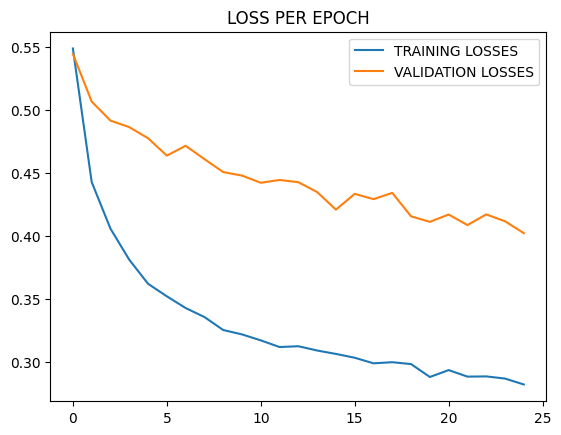

In [13]:
epochs = []

for num in range(num_epochs_logreg):
    epochs.append(num)

plt.plot(epochs, logreg_train_losses)
plt.plot(logreg_valid_losses)
plt.legend(['TRAINING LOSSES', 'VALIDATION LOSSES'])
plt.title("LOSS PER EPOCH")

In [14]:
# EVALUATING THE MODEL WITH THE TEST SET
# INPUT: model (type of model), test_data (testing data (features or embeddings)), test_labels (0 and 1)
# model_name (name of model), embed (boolean value that converts embedding indices into proper type)
def Test(model, test_data, test_labels, model_name, embed = False):
    x = torch.tensor(test_data, dtype = torch.float)
    if (embed == True):
        x = torch.tensor(test_data, dtype = torch.long)
    y_hat = model(x)
    y_hat = list([int(i.round()) for i in y_hat])

    accuracy = metrics.accuracy_score(test_labels, y_hat)
    precision = metrics.precision_score(test_labels, y_hat)
    recall = metrics.recall_score(test_labels, y_hat)
    confusion_matrix = metrics.confusion_matrix(test_labels, y_hat)
    print("ACCURACY SCORE FOR", model_name, "IS:", accuracy)
    print("PRECISION SCORE FOR", model_name, "IS:", precision)
    print("RECALL SCORE FOR", model_name, "IS:", recall, '\n')
    print("CONFUSION MATRIX:", '\n', confusion_matrix)

In [15]:
Test(LogReg, test_set, test_labels, "LOGISTIC REGRESSION")

ACCURACY SCORE FOR LOGISTIC REGRESSION IS: 0.7690707350901526
PRECISION SCORE FOR LOGISTIC REGRESSION IS: 0.966183574879227
RECALL SCORE FOR LOGISTIC REGRESSION IS: 0.5563282336578581 

CONFUSION MATRIX: 
 [[1418   28]
 [ 638  800]]


In [16]:
# TRAINING CNN WITH TF-IDF AND ENGINEERED FEATURES
cnn_train_losses, cnn_valid_losses = SGD(CNN, train_set, train_labels, valid_set, valid_labels, num_epochs_cnn, learning_rate_cnn, False)

TRAINING MODEL:   0%|          | 0/10 [00:00<?, ?it/s]

TRAINING LOSS AT EPOCH 1 IS: 0.6831172704696655
VALIDATION LOSS AT EPOCH 1 IS: 0.6596198678016663 

TRAINING LOSS AT EPOCH 2 IS: 0.4627342224121094
VALIDATION LOSS AT EPOCH 2 IS: 0.4208500385284424 

TRAINING LOSS AT EPOCH 3 IS: 0.17710061371326447
VALIDATION LOSS AT EPOCH 3 IS: 0.3367311954498291 

TRAINING LOSS AT EPOCH 4 IS: 0.09969966858625412
VALIDATION LOSS AT EPOCH 4 IS: 0.25051867961883545 

TRAINING LOSS AT EPOCH 5 IS: 0.0722406730055809
VALIDATION LOSS AT EPOCH 5 IS: 0.20514222979545593 

TRAINING LOSS AT EPOCH 6 IS: 0.05430348590016365
VALIDATION LOSS AT EPOCH 6 IS: 0.202358216047287 

TRAINING LOSS AT EPOCH 7 IS: 0.047012537717819214
VALIDATION LOSS AT EPOCH 7 IS: 0.2316075563430786 

TRAINING LOSS AT EPOCH 8 IS: 0.04143953323364258
VALIDATION LOSS AT EPOCH 8 IS: 0.21421384811401367 

TRAINING LOSS AT EPOCH 9 IS: 0.03606092557311058
VALIDATION LOSS AT EPOCH 9 IS: 0.23894982039928436 

TRAINING LOSS AT EPOCH 10 IS: 0.03299067169427872
VALIDATION LOSS AT EPOCH 10 IS: 0.215526

Text(0.5, 1.0, 'LOSS PER EPOCH')

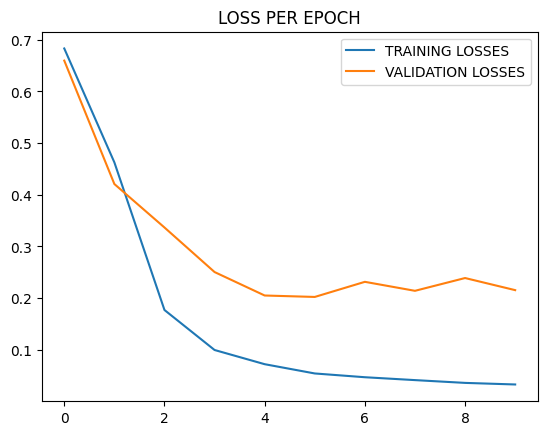

In [17]:
epochs = []

for num in range(num_epochs_cnn):
    epochs.append(num)

plt.plot(epochs, cnn_train_losses)
plt.plot(cnn_valid_losses)
plt.legend(['TRAINING LOSSES', 'VALIDATION LOSSES'])
plt.title("LOSS PER EPOCH")

In [18]:
Test(CNN, test_set, test_labels, "CNN")

ACCURACY SCORE FOR CNN IS: 0.9101941747572816
PRECISION SCORE FOR CNN IS: 0.9667458432304038
RECALL SCORE FOR CNN IS: 0.849095966620306 

CONFUSION MATRIX: 
 [[1404   42]
 [ 217 1221]]


In [19]:
# TRAINING CNN WITH WORD EMBEDDINGS:
cnn_e_train_losses, cnn_e_valid_losses = SGD(CNN_E, train_indices, train_labels, valid_indices, valid_labels, num_epochs_cnn_e, learning_rate_cnn_e, True)

TRAINING MODEL:   0%|          | 0/20 [00:00<?, ?it/s]

TRAINING LOSS AT EPOCH 1 IS: 0.595946192741394
VALIDATION LOSS AT EPOCH 1 IS: 0.5584134459495544 

TRAINING LOSS AT EPOCH 2 IS: 0.5350295305252075
VALIDATION LOSS AT EPOCH 2 IS: 0.4977794587612152 

TRAINING LOSS AT EPOCH 3 IS: 0.5027651190757751
VALIDATION LOSS AT EPOCH 3 IS: 0.4732051193714142 

TRAINING LOSS AT EPOCH 4 IS: 0.4696578085422516
VALIDATION LOSS AT EPOCH 4 IS: 0.47546908259391785 

TRAINING LOSS AT EPOCH 5 IS: 0.457664430141449
VALIDATION LOSS AT EPOCH 5 IS: 0.45770400762557983 

TRAINING LOSS AT EPOCH 6 IS: 0.4378531277179718
VALIDATION LOSS AT EPOCH 6 IS: 0.46044155955314636 

TRAINING LOSS AT EPOCH 7 IS: 0.43103697896003723
VALIDATION LOSS AT EPOCH 7 IS: 0.43778112530708313 

TRAINING LOSS AT EPOCH 8 IS: 0.4247913658618927
VALIDATION LOSS AT EPOCH 8 IS: 0.45132485032081604 

TRAINING LOSS AT EPOCH 9 IS: 0.4092575013637543
VALIDATION LOSS AT EPOCH 9 IS: 0.4433468282222748 

TRAINING LOSS AT EPOCH 10 IS: 0.4106167256832123
VALIDATION LOSS AT EPOCH 10 IS: 0.4284311830997

Text(0.5, 1.0, 'LOSS PER EPOCH')

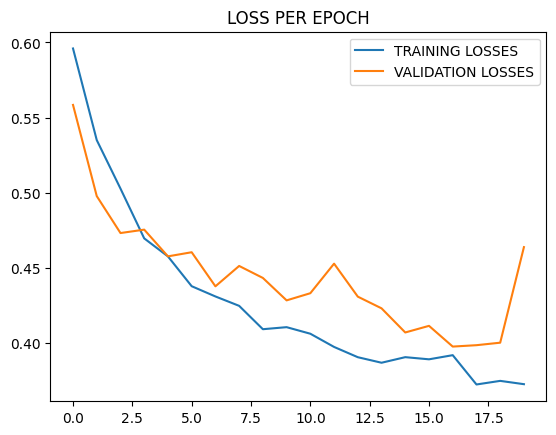

In [20]:
epochs = []

for num in range(num_epochs_cnn_e):
    epochs.append(num)

plt.plot(epochs, cnn_e_train_losses)
plt.plot(cnn_e_valid_losses)
plt.legend(['TRAINING LOSSES', 'VALIDATION LOSSES'])
plt.title("LOSS PER EPOCH")

In [21]:
Test(CNN_E, test_indices, test_labels, "CNN WITH EMBEDDINGS", True)

ACCURACY SCORE FOR CNN WITH EMBEDDINGS IS: 0.8477808599167822
PRECISION SCORE FOR CNN WITH EMBEDDINGS IS: 0.8980079681274901
RECALL SCORE FOR CNN WITH EMBEDDINGS IS: 0.7837273991655076 

CONFUSION MATRIX: 
 [[1318  128]
 [ 311 1127]]
